# Weather and envrionmental data to predict worsening asthma

Triggers (daily):
- 1 = No, I did not encounter any asthma triggers today
- 2 = A cold
- 3 = Exercise or being more active than usual
- 4 = Strong smells / exhaust fumes
- 5 = Mould
- 6 = House dust / dust mites
- 7 = Feathers
- 8 = Dogs / cats / other furry / feathered animals
- 9 = Pollen from trees grass or weeds
- 10 = Extreme heat
- 11 = Extreme cold
- 12 = Changes in weather
- 13 = Poor air quality
- 14 = Someone smoking near me
- 15 = Foods
- 16 = Around the time of my period
- 17 = Feeling sad, angry, excited, tense, stressed
- 18 = Laughter
- 19 = I am not sure
- 20 = Other


(Reported) environmental factors that are measured that relate to outdoor environment:
9, 10, 11, 12, 13




Definition of worsening asthma:
- A day of higher relief inhaler usage than personal median

Y (label):
- 2 days of relief inhaler usage in 3 days after 2 day freezing period > personal median (ATS: moderate attack)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, plot_tree

from sklearn.metrics import roc_curve, auc, precision_recall_curve


pd.set_option('future.no_silent_downcasting', True)

In [ ]:
# ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc, fpr, tpr

# Precision-Recall curve
def plot_pr_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    plt.figure()
    lw = 2
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

    return pr_auc, precision, recall

In [ ]:
# load data
data_folder_path = './data/'
data_folder_path = '/Users/kevin/Documents/data/AAMOS/' ########## CHANGE THIS PATH ##########

daily_raw_df = pd.read_csv(data_folder_path + 'anonym_aamos00_dailyquestionnaire.csv')
env_df = pd.read_csv(data_folder_path + 'anonym_aamos00_environment.csv')
weekly_df = pd.read_csv(data_folder_path + 'anonym_aamos00_weeklyquestionnaire.csv')

In [ ]:
daily_df = daily_raw_df.copy()

In [ ]:
# patient average RCP3
daily_df['rcp3'] = daily_df['daily_night_symp'].astype('Int64') + daily_df['daily_day_symp'].astype('Int64') + daily_df['daily_limit_activity'].astype('Int64')

patient_rcp3 = daily_df.groupby('user_key')['rcp3'].agg({'mean', 'median', 'max', 'min', 'count'}).reset_index()


In [ ]:
daily_df.head(12)

,user_key,date,daily_night_symp,daily_day_symp,daily_limit_activity,daily_prev_inhaler,daily_relief_inhaler,daily_triggers,rcp3
0,113,0,True,True,False,2,5,"5,9",2
1,113,1,False,False,False,2,3,"5,9",0
2,113,2,False,True,False,2,5,"5,9",1
3,113,3,False,False,False,2,1,"5,12",0
4,113,4,False,True,False,2,3,"5,9",1
5,113,5,False,True,False,2,3,"9,12",1
6,113,6,False,True,False,2,3,"9,12",1
7,113,7,True,True,False,2,0,"8,9",2
8,113,8,False,True,False,2,3,"9,12",1
9,113,9,False,False,False,2,3,12,0


In [ ]:
# patient relief inhaler usage
patient_r_inhaler = daily_df.groupby('user_key')['daily_relief_inhaler'].agg({'mean', 'median', 'max', 'min', 'count'}).reset_index()

In [ ]:
# daily processed

# one-hot encoding daily_triggers
daily_df['daily_triggers_sep'] = daily_df['daily_triggers'].str.split(',')

# make no trigger days with empty list
daily_df['daily_triggers_sep'] = daily_df['daily_triggers_sep'].fillna("").apply(list)

mlb = MultiLabelBinarizer()

daily_df = daily_df.join(
    pd.DataFrame(
        mlb.fit_transform(daily_df.pop('daily_triggers_sep')),
        index=daily_df.index,
        columns='daily_trig_'+mlb.classes_))

In [ ]:
# daily triggers
daily_env_trigger_counts = pd.concat([
    daily_df['user_key'], 
    daily_df[['daily_trig_9', 'daily_trig_10', 'daily_trig_11', 'daily_trig_12', 'daily_trig_13']].any(axis=1)
    ], axis=1).groupby('user_key').sum()
# print(daily_env_trigger_counts)

# as a percentage of total days
daily_env_trigger_perc_days = daily_env_trigger_counts.div(daily_df.groupby('user_key')['date'].count(), axis=0).reset_index()

# as a percentage of total days with reported triggers
daily_env_trigger_perc_trigger = daily_env_trigger_counts.div(daily_df.groupby('user_key')['daily_triggers'].count(), axis=0).reset_index()


In [ ]:
# see how many times each patient reported each trigger
# of interest: 9, 10, 11, 12, 13

daily_trigger_counts = daily_df.groupby('user_key').sum().filter(regex='daily_trig_.*')

# as a percentage of total days
daily_trigger_perc_days = daily_trigger_counts.div(daily_df.groupby('user_key')['date'].count(), axis=0).reset_index()

# as a percentage of total days with reported triggers
daily_trigger_perc_trigger = daily_trigger_counts.div(daily_df.groupby('user_key')['daily_triggers'].count(), axis=0).reset_index()


### create ml_df
Met office and UK Health Security Agency (UKHSA) threshold for extreme heat and cold:

https://assets.publishing.service.gov.uk/media/65450c2b59b9f5001385a240/User-guide-impact-based-weather-and-health-alerting-system.pdf

In [ ]:
def get_grad(x, min_count=2, min_value=1e-6): 
    """Calculate gradient of a pandas Series x using linear regression (numpy polyfit)."""
    idx = ~x.isna()

    # if no values or singular, return np.nan
    if (x.count() < min_count):
        return np.nan
    
    # if constant, return 0
    elif x.nunique() == 1:
        return 0

    try:
        grad = np.polyfit(np.array(x.index[idx], dtype=float),
                          np.array(x.values[idx], dtype=float),
                          1)[0]
        if abs(grad) < min_value:
            return 0
        return grad

    except:
        return np.nan

def get_latest(x):
    if x.count() == 0:
        return np.nan
    else:
        return x[x.last_valid_index()]

In [ ]:
def create_ml_df(
        LOOKBACK_DAYS = 7,
        LOOKFORWARD_DAYS_FREEZING = 2,
        LOOKFORWARD_DAYS_PREDICT = 3):
    """
    Create machine learning dataframe with features and target variable.

    Parameters:
    LOOKBACK_DAYS: int
        Number of days to look back for feature aggregation.
    LOOKFORWARD_DAYS_FREEZING: int
        Number of days to look forward as a freezing period allowing for actions.
    LOOKFORWARD_DAYS_PREDICT: int
        Number of days to look forward for predicting asthma attack, excluding the freezing period.
    """

    global env_df
    global daily_df

    ml_df = daily_df.copy()

    # look up median relief inhaler usage
    ml_df = ml_df.merge(patient_r_inhaler[['user_key', 'median']].rename(columns={'median': 'median_r_inhaler'}),
                        on='user_key', how='left')
    
    
    # check if currently in attack
    ml_df['current_attack'] = ml_df['daily_relief_inhaler'] > ml_df['median_r_inhaler']

    # add empty rows for each patient between the start and end date

    filled_patients_dates_lookup = daily_df.groupby('user_key')['date'].agg({'min', 'max'}).reset_index()
    filled_patients_dates_lookup

    filled_patients_dates = pd.DataFrame(columns=['user_key', 'date'])

    for i, row in filled_patients_dates_lookup.iterrows():
        start_date = row['min']
        end_date = row['max']
        for date_i in range(start_date, end_date+1):
            filled_patients_dates = pd.concat([filled_patients_dates, 
                                            pd.DataFrame({'user_key': [row['user_key']], 'date': [date_i]})], 
                                            axis= 0,
                                            ignore_index=True)
            

    ml_df = ml_df.merge(filled_patients_dates, on=['user_key', 'date'], how='right')

    # # make NaN to None
    ml_df = ml_df.replace(np.nan, None)


    # ---------------------------
    # add label of attack 
    # ---------------------------

    ml_df['lookback_start'] = ml_df['date'] - LOOKBACK_DAYS
    ml_df['lookback_end'] = ml_df['date'] - 1

    ml_df['lookforward_start'] = ml_df['date'] + LOOKFORWARD_DAYS_FREEZING
    ml_df['lookforward_end'] = ml_df['date'] + LOOKFORWARD_DAYS_FREEZING + LOOKFORWARD_DAYS_PREDICT

    # for each patient see if worsening asthma in lookforward window 
    ml_df['lookforward_attack'] = None
    for i in range(len(ml_df)):
        user_key = ml_df.loc[i, 'user_key']
        lookforward_start = ml_df.loc[i, 'lookforward_start']
        lookforward_end = ml_df.loc[i, 'lookforward_end']
        lookforward_attack_series = ml_df.loc[
            (ml_df['user_key'] == user_key) &
            (ml_df['date'] >= lookforward_start) & 
            (ml_df['date'] <= lookforward_end), 
            'current_attack']
        if len(lookforward_attack_series) < 2:
            ml_df.loc[i, 'lookforward_attack'] = None
        elif all(lookforward_attack_series.isna()):
            ml_df.loc[i, 'lookforward_attack'] = None
        else:
            ml_df.loc[i, 'lookforward_attack'] = sum(lookforward_attack_series.fillna(0)) >= 2


    def make_agg_columns(i, df_agg, df_raw, feature_name):
        df_raw_feature = df_raw[feature_name].copy()

        df_agg.loc[i, feature_name+'_max'] = df_raw_feature.max()
        df_agg.loc[i, feature_name+'_min'] = df_raw_feature.min()
        df_agg.loc[i, feature_name+'_mean'] = df_raw_feature.mean()
        df_agg.loc[i, feature_name+'_range'] = df_raw_feature.max() - df_raw_feature.min()
        df_agg.loc[i, feature_name+'_skew'] = df_raw_feature.skew()
        df_agg.loc[i, feature_name+'_gradient'] = get_grad(df_raw_feature)
        df_agg.loc[i, feature_name+'_median'] = df_raw_feature.median()
        df_agg.loc[i, feature_name+'_latest'] = get_latest(df_raw_feature)
        return df_agg

    # ---------------------------
    # aggregate daily questionnaires
    # ---------------------------
            
    daily_agg_raw_df = daily_df.copy()

    # change data type
    columns_to_convert = ['daily_day_symp', 'daily_night_symp', 'daily_limit_activity']

    for column in columns_to_convert:
        daily_agg_raw_df[column] = daily_agg_raw_df[column].astype(float)

    global daily_agg_df # so that the column names could be used
    daily_agg_df = ml_df[['user_key', 'date', 'lookback_start', 'lookback_end']].copy()


    for i in range(len(daily_agg_df)):
        user_key = daily_agg_df.loc[i, 'user_key']
        lookback_start = daily_agg_df.loc[i, 'lookback_start']
        lookback_end = daily_agg_df.loc[i, 'lookback_end']

        daily_lookback = daily_agg_raw_df.loc[
            (daily_agg_raw_df['user_key'] == user_key) &
            (daily_agg_raw_df['date'] >= lookback_start) &
            (daily_agg_raw_df['date'] <= lookback_end)]
        
        # daily_agg_df.loc[i, 'n_daily_points'] = daily_lookback.shape[0]
        # count rows with not all nan 
        daily_agg_df.loc[i, 'n_daily_points'] = sum(daily_lookback.shape[1] - daily_lookback.isna().sum(axis=1) > 4) # 4 is the number of columns from ml_df

        # rcp3
        daily_agg_df = make_agg_columns(i, daily_agg_df, daily_lookback, 'rcp3')

        daily_agg_df = make_agg_columns(i, daily_agg_df, daily_lookback, 'daily_day_symp')
        daily_agg_df = make_agg_columns(i, daily_agg_df, daily_lookback, 'daily_night_symp')
        daily_agg_df = make_agg_columns(i, daily_agg_df, daily_lookback, 'daily_limit_activity')
        daily_agg_df = make_agg_columns(i, daily_agg_df, daily_lookback, 'daily_prev_inhaler')

        # relief inhaler daily_lookback['daily_relief_inhaler'] (this is the target variable)

        # triggers
        daily_agg_df.loc[i, 'daily_trig_count_mean'] = daily_lookback.loc[:,'daily_trig_'+mlb.classes_].sum(axis=1).mean()
        daily_agg_df.loc[i, 'daily_trig_count_max'] = daily_lookback.loc[:,'daily_trig_'+mlb.classes_].sum(axis=1).max()
        daily_agg_df.loc[i, 'daily_trig_count_min'] = daily_lookback.loc[:,'daily_trig_'+mlb.classes_].sum(axis=1).min()

        for class_ in mlb.classes_:
            daily_agg_df.loc[i, 'daily_trig_'+class_+'_count_mean'] = daily_lookback.loc[:,'daily_trig_'+class_].mean(axis=0)
            daily_agg_df.loc[i, 'daily_trig_'+class_+'_count_any'] = daily_lookback.loc[:,'daily_trig_'+class_].any(axis=0)
        
    daily_agg_df.drop(columns=['lookback_start', 'lookback_end'], inplace=True)


    # ---------------------------
    # aggregate environmental data
    # ---------------------------

    # aggregate between lookback_start and lookback_end
    env_agg_raw_df = env_df.merge(ml_df[['user_key', 'date', 'lookback_start', 'lookback_end']], on=['user_key', 'date'], how='outer')

    # change pollen Low, Moderate, High to 1, 2, 3
    pollen_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
    env_agg_raw_df['grass_pollen'] = env_agg_raw_df['grass_pollen'].map(pollen_mapping)
    env_agg_raw_df['tree_pollen'] = env_agg_raw_df['tree_pollen'].map(pollen_mapping)
    env_agg_raw_df['weed_pollen'] = env_agg_raw_df['weed_pollen'].map(pollen_mapping)

    # calculate features relating to 
    # - 12 = Pollen from trees grass or weeds
    # - 13 = Extreme heat
    # - 14 = Extreme cold
    # - 15 = Changes in weather
    # - 17 = Poor air quality
    global env_agg_df # so that the column names could be used
    env_agg_df = env_agg_raw_df[['user_key', 'date']].copy()

    for i in range(len(env_agg_df)):
        user_key = env_agg_raw_df.loc[i, 'user_key']
        lookback_start = env_agg_raw_df.loc[i, 'lookback_start']
        lookback_end = env_agg_raw_df.loc[i, 'lookback_end']

        env_lookback = env_agg_raw_df.loc[
            (env_agg_raw_df['user_key'] == user_key) &
            (env_agg_raw_df['date'] >= lookback_start) &
            (env_agg_raw_df['date'] <= lookback_end)]

        # env_agg_df.loc[i, 'n_env_points'] = env_lookback.shape[0]
        # count rows with not all nan 
        env_agg_df.loc[i, 'n_env_points'] = sum(env_lookback.shape[1] - env_lookback.isna().sum(axis=1) > 4) # 4 is the number of columns from ml_df

        # pollen
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'grass_pollen')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'tree_pollen')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'weed_pollen')

        
        # extreme heat (days over 27C) Met office
        ex_heat = env_lookback['temperature_max'] > 27
        if all(env_lookback['temperature_max'].isna()):
            env_agg_df.loc[i, 'extreme_heat'] = None
        else:
            env_agg_df.loc[i, 'extreme_heat'] = any(ex_heat)


        # extreme cold (days under 2C)
        ex_cold = env_lookback['temperature_min'] < 2
        if all(env_lookback['temperature_min'].isna()):
            env_agg_df.loc[i, 'extreme_cold'] = None
        else:
            env_agg_df.loc[i, 'extreme_cold'] = any(ex_cold)

        # cold weather?

        # changes in weather (temperature, humidity, wind speed)

        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'temperature')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'temperature_max')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'temperature_min')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'humidity')
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'wind_speed')

        # poor air quality
        env_agg_df = make_agg_columns(i, env_agg_df, env_lookback, 'aqi')



    # ---------------------------
    # reported triggers through daily questionnaires
    # ---------------------------

    # check known triggers vs reported daily triggers
    reported_triggers = daily_agg_df.groupby('user_key').any().filter(regex='daily_trig_.*_count_any')
    reported_triggers = reported_triggers.reset_index()

    # rename columns to r_trig_*
    reported_triggers.columns = ['user_key'] + ['r_trig_'+i.split('_')[2] for i in reported_triggers.columns[1:]]

    reported_triggers['r_env_trigger'] = reported_triggers.loc[:,reported_triggers.columns.str.contains('r_trig_9|r_trig_10|r_trig_11|r_trig_12|r_trig_13')].any(axis=1)



    # ---------------------------
    # merge data
    # ---------------------------

    # look up patient's reported triggers
    ml_df = ml_df.merge(reported_triggers[['user_key', 'r_env_trigger']], on='user_key', how='left')

    # clean up ml_df
    ml_df = ml_df[['user_key', 'date', 'r_env_trigger', 'current_attack', 'lookforward_attack']].copy()

    # join daily_agg_df
    ml_df = ml_df.merge(daily_agg_df, on=['user_key','date'], how='left')

    # join env_df
    ml_df = ml_df.merge(env_agg_df, on=['user_key','date'], how='left')


    # ---------------------------
    # final clean up
    # ---------------------------
    # convert data types
    # extreme heat, extreme cold, lookforward_attack
    # convert data types
    columns_to_convert = [
        'extreme_heat', 'extreme_cold', 'lookforward_attack', 
        'daily_day_symp_max', 'daily_day_symp_min', 
        'daily_night_symp_max', 'daily_night_symp_min', 
        'daily_limit_activity_max', 'daily_limit_activity_min'] + ['daily_trig_'+class_+'_count_any' for class_ in mlb.classes_]

    for column in columns_to_convert:
        ml_df[column] = ml_df[column].astype(float)
    
    ml_df['user_key'] = ml_df['user_key'].astype('category')
    ml_df['date'] = ml_df['date'].astype(int)


    # drop rows with no lookforward_attack
    ml_df = ml_df.dropna(subset=['lookforward_attack']).copy()

    # add random noise as a feature
    # ml_df['rand_normal'] = np.random.normal(size=len(ml_df))
    # ml_df['rand_const0'] = 0
    # ml_df['rand_const1'] = 1

    return ml_df


----
## Train models


In [ ]:
def train_xgboost(X_train, y_train, X_test, y_test, model_name, n_features=10,plot_graphs=False, n_estimators=10, max_depth=2):

    # class balance
    npositive_train = sum(y_train == 1)
    npositive_test = sum(y_test == 1)

    # if only one class in train or test set raise error
    if len(y_train.value_counts()) != 2:
        raise ValueError('Need 2 classes in train set')
    if len(y_test.value_counts()) != 2:
        raise ValueError('Need 2 classes in test set')
    
    # drop user_key
    X_train_user_key = X_train['user_key']
    X_test_user_key = X_test['user_key']
    X_train = X_train.drop(columns=['user_key'])
    X_test = X_test.drop(columns=['user_key'])
    
    # train model
    bst_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, objective='binary:logistic', enable_categorical=True, device='cuda')
    bst_model.fit(X_train, y_train)

    pred = bst_model.predict_proba(X_test)

    # just use the probability of attack
    pred = pred[:,1]

    # plot graphs
    if plot_graphs:
        roc_auc, fpr, tpr = plot_roc_curve(y_test, pred)
        pr_auc, precision, recall = plot_pr_curve(y_test, pred)
    else:
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, pred)
        pr_auc = auc(recall, precision)

    # use GMA to find the best threshold
    gma = np.sqrt(tpr * (1-fpr))
    best_threshold = np.argmax(gma)
    best_sen = tpr[best_threshold]
    best_spec = 1 - fpr[best_threshold]

    # feature importance (default weight)
    # feature_importance = bst_model.feature_importances_
    # feature_names = X_train.columns
    # feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance}).sort_values(by='importance', ascending=False)
    # feature_importance_df['model'] = model_name

    # feature importance (permutation importance)
    r = permutation_importance(bst_model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = r.importances_mean
    feature_names = X_test.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance}).sort_values(by='importance', ascending=False)
    feature_importance_df['model'] = model_name

    
    # summary
    summary = {
        'model' : model_name,
        'aucroc' : roc_auc,
        'auprc' : pr_auc,
        'auprc_inc' : pr_auc / (npositive_test/len(y_test)),
        'best_sen' : best_sen,
        'best_spec' : best_spec,
        'ntrain' : len(y_train), 
        'ntest' : len(y_test),
        'nfeatures_train' : X_train.shape[1],
        'nfeatures_important' : sum(feature_importance_df['importance'] > 0),
        'npositive_train' : npositive_train,
        'npositive_test' : npositive_test,
        # 'npatients_train' : len(X_train['user_key'].unique()),
        # 'npatients_test' : len(X_train['user_key'].unique())
        'npatients_train' : len(X_train_user_key.unique()),
        'npatients_test' : len(X_test_user_key.unique())
        }



    return bst_model, pred, summary, feature_importance_df

In [108]:
def get_train_idx(data_for_split, perc_split):
    if perc_split < 0 or perc_split > 1:
        raise ValueError('perc_split must be between 0 and 1')
    
    if data_for_split.empty:
        Warning('data_for_split is empty')

    split_point = data_for_split.groupby('user_key', observed=False)['date'].quantile(perc_split).reset_index()


    # get index of before and after each user's split point
    split_date = data_for_split[['user_key','date']].merge(split_point.rename(columns={'date':'split_date'}), on='user_key', how='left')
    split_idx = split_date['date'] <= split_date['split_date']
    split_idx = np.array(split_idx)
    return split_idx

def day_split_train_xgboost(model_summary_df,feature_importance_df, X, y, model_name, train_idx, day_split, s=1, n_estimators=8, max_depth=3):

    np.random.seed(s)

    if sum(train_idx) == 0 or sum(~train_idx) == 0:
        print(f"No data for train or test for day split {day_split} with seed {s}")
        return model_summary_df, feature_importance_df

    try:
        X_train = X[train_idx].astype(dtype='Float64')
        y_train = y[train_idx]
        X_test = X[~train_idx].astype(dtype='Float64')
        y_test = y[~train_idx]
    except Exception as e:
        print(e)


    try:
        _,_, model_summary, feature_importance = train_xgboost(X_train, y_train, X_test, y_test, model_name, n_estimators=n_estimators, max_depth=max_depth)

        model_summary['day_split'] = day_split
        model_summary['seed'] = s

        model_summary_df = pd.concat([model_summary_df, pd.DataFrame(model_summary, index=[day_split])])

        feature_importance['day_split'] = day_split
        feature_importance['seed'] = s
        feature_importance_df = pd.concat([feature_importance_df, feature_importance])
    except Exception as e:
        print(f"Error training model {model_name} on day split {day_split} with seed {s}: {e}")
        pass
    return model_summary_df, feature_importance_df


def train_models_day_split(day_split, CV_REPEAT=50, min_raw_points = 3, n_estimators=50, max_depth=2): # can change the n_estimator and max_depth params here
    model_summary_df = pd.DataFrame()
    feature_importance_df = pd.DataFrame()

    global weather_patient_ml_df
    global non_weather_patient_ml_df

    global X_drop_columns
    global X_active_columns
    global X_passive_columns



    for d in day_split:
        for s in range(CV_REPEAT):
            # ---- PASSIVE vs ACTIVE ----
            # --------------------
            # passive model
            # train weather patient model
            data_for_split = weather_patient_ml_df[weather_patient_ml_df['n_env_points'] >= min_raw_points].copy()

            # train_idx = data_for_split['date'] <= d
            train_idx = get_train_idx(data_for_split, d)
            X = data_for_split.drop(columns=X_drop_columns + X_active_columns)
            y = data_for_split['lookforward_attack']
            model_name = 'weather_patient_passive'
            model_summary_df, feature_importance_df = day_split_train_xgboost(model_summary_df, feature_importance_df, X, y, model_name, train_idx, d, s, n_estimators, max_depth)

            

            # --------------------
            # active model
            # train weather patient model
            data_for_split = weather_patient_ml_df[weather_patient_ml_df['n_daily_points'] >= min_raw_points].copy()

            # train_idx = data_for_split['date'] <= d
            train_idx = get_train_idx(data_for_split, d)
            X = data_for_split.drop(columns=X_drop_columns + X_passive_columns)
            y = data_for_split['lookforward_attack']
            model_name = 'weather_patient_active'
            model_summary_df, feature_importance_df = day_split_train_xgboost(model_summary_df, feature_importance_df, X, y, model_name, train_idx, d, s, n_estimators, max_depth)


            # --------------------
            # passive model
            # train non-weather patient model
            data_for_split = non_weather_patient_ml_df[non_weather_patient_ml_df['n_env_points'] >= min_raw_points].copy()

            # train_idx = data_for_split['date'] <= d
            train_idx = get_train_idx(data_for_split, d)
            X = data_for_split.drop(columns=X_drop_columns + X_active_columns)
            y = data_for_split['lookforward_attack']
            model_name = 'nonweather_patient_passive'
            model_summary_df, feature_importance_df = day_split_train_xgboost(model_summary_df, feature_importance_df, X, y, model_name, train_idx, d, s, n_estimators, max_depth)
            

            # --------------------
            # active model
            # train non-weather patient model
            data_for_split = non_weather_patient_ml_df[non_weather_patient_ml_df['n_daily_points'] >= min_raw_points].copy()

            # train_idx = data_for_split['date'] <= d
            train_idx = get_train_idx(data_for_split, d)
            X = data_for_split.drop(columns=X_drop_columns + X_passive_columns)
            y = data_for_split['lookforward_attack']
            model_name = 'nonweather_patient_active'
            model_summary_df, feature_importance_df = day_split_train_xgboost(model_summary_df, feature_importance_df, X, y, model_name, train_idx, d, s, n_estimators, max_depth)


    return model_summary_df, feature_importance_df

In [ ]:
def q25(column): 
    return column.quantile(0.25)

def q75(column):
    return column.quantile(0.75)

def p05(column): 
    return column.quantile(0.05)

def p95(column):
    return column.quantile(0.95)

In [ ]:
# import 
# all_model_summary_df = pd.read_csv('./outputs/performance/all_model_summary_df.csv')
# all_feature_importance_df = pd.read_csv('./outputs/feature_importance/all_feature_importance_df.csv')

Train models across parameter grid of :
- lookback_days: 5, 7, 14, 21, 28
- lookforward_days_freezing: 2
- lookforward_days_predict: 3, 4, 5

Computing model performance at 15 combinations takes around 15 minutes on a standard laptop. `create_ml_df` function is the bottleneck.

In [95]:
all_model_summary_df = pd.DataFrame()
all_feature_importance_df = pd.DataFrame()

In [96]:
# optimal parameters are 
# lookback_days = 7
# lookforward_days_freezing = 2
# lookforward_days_predict = 3

CV_REPEAT = 1

for lookback_days in [5,7,14,21,28]:
    for lookforward_days_freezing in [2]:
        for lookforward_days_predict in [3,4,5]:

            print(f'Training: LOOKBACK_DAYS = {lookback_days}, LOOKFORWARD_DAYS_FREEZING = {lookforward_days_freezing}, LOOKFORWARD_DAYS_PREDICT = {lookforward_days_predict}')

            ml_df = create_ml_df(
                LOOKBACK_DAYS = lookback_days,
                LOOKFORWARD_DAYS_FREEZING = lookforward_days_freezing,
                LOOKFORWARD_DAYS_PREDICT = lookforward_days_predict)

            # patients who reported environmental triggers more than 50% of the time
            weather_patient_ml_df = ml_df.loc[ml_df['user_key'].isin(daily_env_trigger_perc_trigger.loc[daily_env_trigger_perc_trigger[0] >= 0.3, 'user_key'])]
            non_weather_patient_ml_df = ml_df.loc[ml_df['user_key'].isin(daily_env_trigger_perc_trigger.loc[daily_env_trigger_perc_trigger[0] < 0.3, 'user_key'])]


            # ---- Feature names ----
            # select features to use
            X_drop_columns = ['date', 'current_attack', 'lookforward_attack', 'r_env_trigger', 'n_daily_points', 'n_env_points']
            # X_drop_columns = ['user_key'] + X_drop_columns
            X_active_columns = daily_agg_df.columns[2:].tolist()
            X_passive_columns = env_agg_df.columns[2:].tolist()


            # drop columns relating to daily triggers from questionnaire
            X_drop_columns = X_drop_columns + ml_df.columns[ml_df.columns.str.startswith('daily_trig_')].tolist()



            # ---- Train models ----
            model_summary_df, feature_importance_df = train_models_day_split(day_split=[0.7], CV_REPEAT=CV_REPEAT, min_raw_points=3)
            model_summary_df['lookback_days'] = lookback_days
            model_summary_df['lookforward_days_freezing'] = lookforward_days_freezing
            model_summary_df['lookforward_days_predict'] = lookforward_days_predict

            feature_importance_df['lookback_days'] = lookback_days
            feature_importance_df['lookforward_days_freezing'] = lookforward_days_freezing
            feature_importance_df['lookforward_days_predict'] = lookforward_days_predict

            all_model_summary_df = pd.concat([all_model_summary_df, model_summary_df])
            all_feature_importance_df = pd.concat([all_feature_importance_df, feature_importance_df])

Training: LOOKBACK_DAYS = 5, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 3
Training: LOOKBACK_DAYS = 5, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 4
Training: LOOKBACK_DAYS = 5, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 5
Training: LOOKBACK_DAYS = 7, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 3
Training: LOOKBACK_DAYS = 7, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 4
Training: LOOKBACK_DAYS = 7, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 5
Training: LOOKBACK_DAYS = 14, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 3
Training: LOOKBACK_DAYS = 14, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 4
Training: LOOKBACK_DAYS = 14, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 5
Training: LOOKBACK_DAYS = 21, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 3
Training: LOOKBACK_DAYS = 21, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 4
Training: LOOKBA

In [ ]:
# clean up

all_model_summary_plot_df = all_model_summary_df[
    all_model_summary_df['lookforward_days_freezing'] == 2
].copy()
all_model_summary_plot_df = all_model_summary_plot_df[[
    'lookback_days', 'lookforward_days_freezing', 'lookforward_days_predict', 
    'model', 'aucroc', 'auprc_inc', 'nfeatures_important']]

all_model_summary_plot_df['trigger'] = all_model_summary_plot_df['model'].str.split('_').str[0]
all_model_summary_plot_df['patient'] = all_model_summary_plot_df['model'].str.split('_').str[1]
all_model_summary_plot_df['data'] = all_model_summary_plot_df['model'].str.split('_').str[2]

all_model_summary_plot_df['trigger_patient'] = all_model_summary_plot_df['trigger'] + '_' + all_model_summary_plot_df['patient']
all_model_summary_plot_df['look_set'] = all_model_summary_plot_df['lookback_days'].astype('str') + '_' + \
    all_model_summary_plot_df['lookforward_days_freezing'].astype('str') + '_' + \
        all_model_summary_plot_df['lookforward_days_predict'].astype('str')

# drop all_patient
all_model_summary_plot_df = all_model_summary_plot_df[all_model_summary_plot_df['trigger'] != 'all']


all_model_summary_plot_df = all_model_summary_plot_df.groupby(['look_set', 'model']).agg({
    'aucroc': 'median',
    'auprc_inc': 'median',
    'trigger_patient' : 'first',
    'lookback_days': 'first',
    'lookforward_days_freezing': 'first',
    'lookforward_days_predict': 'first'
}).reset_index()


In [ ]:
# export (optional)
# all_model_summary_plot_df.to_csv('./outputs/performance/all_model_summary_df.csv', index=False)
# all_feature_importance_df.to_csv('./outputs/feature_importance/all_feature_importance_df.csv', index=False)

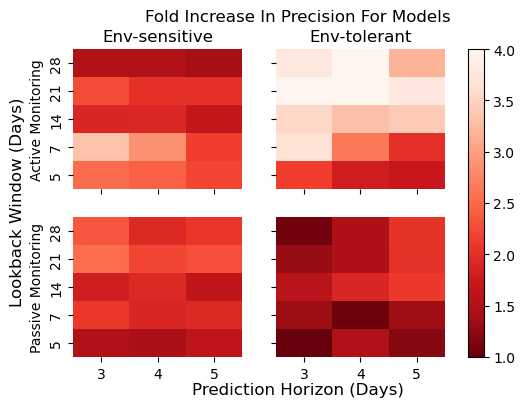

In [ ]:
# 2d plot of auprc_inc for lookback_days vs lookforward_days_predict
weather_patient_active_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='weather_patient_active'].pivot(index='lookback_days', columns='lookforward_days_predict', values='auprc_inc').sort_index(ascending=False)
nonweather_patient_active_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='nonweather_patient_active'].pivot(index='lookback_days', columns='lookforward_days_predict', values='auprc_inc').sort_index(ascending=False)


weather_patient_passive_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='weather_patient_passive'].pivot(index='lookback_days', columns='lookforward_days_predict', values='auprc_inc').sort_index(ascending=False)
nonweather_patient_passive_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='nonweather_patient_passive'].pivot(index='lookback_days', columns='lookforward_days_predict', values='auprc_inc').sort_index(ascending=False)


annot = False
colour_palette = 'Reds_r'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 4))

# Plot 1: weather_patient_active_performance
sns.heatmap(
    weather_patient_active_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=1, vmax=4,
    ax=ax1,
    cbar=False
)
ax1.set_title('Env-sensitive')
ax1.set_xlabel('')
ax1.set_ylabel('Active Monitoring')
ax1.set_xticklabels([])

# Plot 2: nonweather_patient_active_performance
sns.heatmap(
    nonweather_patient_active_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=1, vmax=4,
    ax=ax2,
    cbar=False
)
ax2.set_title('Env-tolerant')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Plot 3: weather_patient_passive_performance
sns.heatmap(
    weather_patient_passive_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=1, vmax=4,
    ax=ax3,
    cbar=False
)
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('Passive Monitoring')

# Plot 4: nonweather_patient_passive_performance
sns.heatmap(
    nonweather_patient_passive_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=1, vmax=4,
    ax=ax4,
    cbar=False
)
ax4.set_title('')
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_yticklabels([])

fig.colorbar(ax1.get_children()[0], ax=[ax1, ax2, ax3, ax4], location='right')#, use_gridspec=False)#, pad=0.2)
fig.supylabel('Lookback Window (Days)')
fig.supxlabel('Prediction Horizon (Days)')

fig.suptitle('Fold Increase In Precision For Models')
# plt.tight_layout()
plt.savefig('./outputs/performance/thresholds_all_auprc.svg', dpi=300, bbox_inches='tight')
plt.show()


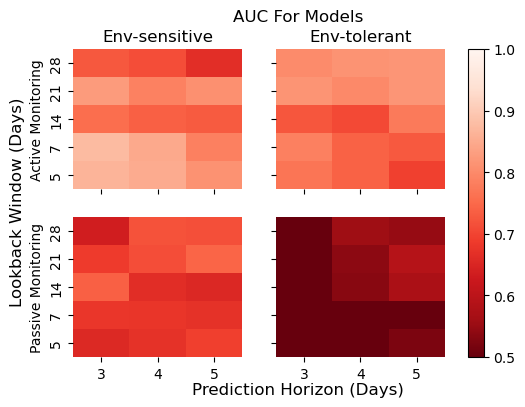

In [ ]:
# 2d plot of auprc_inc for lookback_days vs lookforward_days_predict
weather_patient_passive_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='weather_patient_passive'].pivot(index='lookback_days', columns='lookforward_days_predict', values='aucroc').sort_index(ascending=False)
nonweather_patient_passive_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='nonweather_patient_passive'].pivot(index='lookback_days', columns='lookforward_days_predict', values='aucroc').sort_index(ascending=False)
weather_patient_active_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='weather_patient_active'].pivot(index='lookback_days', columns='lookforward_days_predict', values='aucroc').sort_index(ascending=False)
nonweather_patient_active_performance = all_model_summary_plot_df[all_model_summary_plot_df['model']=='nonweather_patient_active'].pivot(index='lookback_days', columns='lookforward_days_predict', values='aucroc').sort_index(ascending=False)

annot = False
colour_palette = 'Reds_r'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 4))

# Plot 1: weather_patient_active_performance
sns.heatmap(
    weather_patient_active_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=0.5, vmax=1,
    ax=ax1,
    cbar=False
)
ax1.set_title('Env-sensitive')
ax1.set_xlabel('')
ax1.set_ylabel('Active Monitoring')
ax1.set_xticklabels([])

# Plot 2: nonweather_patient_active_performance
sns.heatmap(
    nonweather_patient_active_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=0.5, vmax=1,
    ax=ax2,
    cbar=False
)
ax2.set_title('Env-tolerant')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Plot 3: weather_patient_passive_performance
sns.heatmap(
    weather_patient_passive_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=0.5, vmax=1,
    ax=ax3,
    cbar=False
)
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('Passive Monitoring')

# Plot 4: nonweather_patient_passive_performance
sns.heatmap(
    nonweather_patient_passive_performance,
    annot=annot, fmt=".2f", 
    cmap=colour_palette,
    vmin=0.5, vmax=1,
    ax=ax4,
    cbar=False
)
ax4.set_title('')
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_yticklabels([])

fig.colorbar(ax1.get_children()[0], ax=[ax1, ax2, ax3, ax4], location='right')#, use_gridspec=False)#, pad=0.2)
fig.supylabel('Lookback Window (Days)')
fig.supxlabel('Prediction Horizon (Days)')

fig.suptitle('AUC For Models')
# plt.tight_layout()
plt.savefig('./outputs/performance/thresholds_all_aucroc.svg', dpi=300, bbox_inches='tight')
plt.show()


----
# Robustness (weather split)

In [109]:
lookback_days = 7
lookforward_days_freezing = 2
lookforward_days_predict = 3

weather_split_perc = np.linspace(0,1,11)
num_weather_patients = []

all_weather_split_model_summary_df = pd.DataFrame()
all_weather_split_feature_importance_df = pd.DataFrame()

print(f'Training: LOOKBACK_DAYS = {lookback_days}, LOOKFORWARD_DAYS_FREEZING = {lookforward_days_freezing}, LOOKFORWARD_DAYS_PREDICT = {lookforward_days_predict}')

ml_df = create_ml_df(
    LOOKBACK_DAYS = lookback_days,
    LOOKFORWARD_DAYS_FREEZING = lookforward_days_freezing,
    LOOKFORWARD_DAYS_PREDICT = lookforward_days_predict)

for split_perc in weather_split_perc:
    print(f'weather split = {split_perc}')
    # patients who reported environmental triggers more than split_perc% of the time
    weather_patient_ml_df = ml_df.loc[ml_df['user_key'].isin(daily_env_trigger_perc_trigger.loc[daily_env_trigger_perc_trigger[0] >= split_perc, 'user_key'])]
    non_weather_patient_ml_df = ml_df.loc[ml_df['user_key'].isin(daily_env_trigger_perc_trigger.loc[daily_env_trigger_perc_trigger[0] < split_perc, 'user_key'])]

    print(f'there are {len(weather_patient_ml_df.user_key.unique())} weather patients and {len(non_weather_patient_ml_df.user_key.unique())} non-weather patients')

    num_weather_patients.append(len(weather_patient_ml_df.user_key.unique()))

    # ---- Feature names ----
    # select features to use
    X_drop_columns = ['date', 'current_attack', 'lookforward_attack', 'r_env_trigger', 'n_daily_points', 'n_env_points']
    # X_drop_columns = ['user_key'] + X_drop_columns
    X_active_columns = daily_agg_df.columns[2:].tolist()
    X_passive_columns = env_agg_df.columns[2:].tolist()


    # drop columns relating to daily triggers from questionnaire
    X_drop_columns = X_drop_columns + ml_df.columns[ml_df.columns.str.startswith('daily_trig_')].tolist()



    # ---- Train models ----
    model_summary_df, feature_importance_df = train_models_day_split(day_split=[0.7], CV_REPEAT=CV_REPEAT)


    model_summary_df['lookback_days'] = lookback_days
    model_summary_df['lookforward_days_freezing'] = lookforward_days_freezing
    model_summary_df['lookforward_days_predict'] = lookforward_days_predict
    model_summary_df['weather_split'] = split_perc

    feature_importance_df['lookback_days'] = lookback_days
    feature_importance_df['lookforward_days_freezing'] = lookforward_days_freezing
    feature_importance_df['lookforward_days_predict'] = lookforward_days_predict
    feature_importance_df['weather_split'] = split_perc

    all_weather_split_model_summary_df = pd.concat([all_weather_split_model_summary_df, model_summary_df])
    all_weather_split_feature_importance_df = pd.concat([all_weather_split_feature_importance_df, feature_importance_df])

Training: LOOKBACK_DAYS = 7, LOOKFORWARD_DAYS_FREEZING = 2, LOOKFORWARD_DAYS_PREDICT = 3
weather split = 0.0
there are 21 weather patients and 0 non-weather patients
No data for train or test for day split 0.7 with seed 0
No data for train or test for day split 0.7 with seed 0
weather split = 0.1
there are 17 weather patients and 4 non-weather patients
weather split = 0.2
there are 14 weather patients and 7 non-weather patients
weather split = 0.30000000000000004
there are 11 weather patients and 10 non-weather patients
weather split = 0.4
there are 8 weather patients and 13 non-weather patients
weather split = 0.5
there are 6 weather patients and 15 non-weather patients
weather split = 0.6000000000000001
there are 3 weather patients and 18 non-weather patients
Error training model weather_patient_passive on day split 0.7 with seed 0: Need 2 classes in test set
Error training model weather_patient_active on day split 0.7 with seed 0: Need 2 classes in test set
weather split = 0.7000000

In [ ]:
# export (optional)
# all_weather_split_model_summary_df.to_csv('./outputs/performance/all_weather_split_model_summary_df.csv')
# all_weather_split_feature_importance_df.to_csv('./outputs/feature_importance/all_weather_split_feature_importance_df.csv')

In [110]:
all_weather_split_model_summary_plot_df = all_weather_split_model_summary_df[
    all_weather_split_model_summary_df['day_split'] == 0.7
].copy()
all_weather_split_model_summary_plot_df = all_weather_split_model_summary_plot_df[[
    'lookback_days', 'lookforward_days_freezing', 'lookforward_days_predict', 'weather_split',
    'model', 'aucroc', 'auprc_inc', 'nfeatures_important']]

all_weather_split_model_summary_plot_df['trigger'] = all_weather_split_model_summary_plot_df['model'].str.split('_').str[0]
all_weather_split_model_summary_plot_df['patient'] = all_weather_split_model_summary_plot_df['model'].str.split('_').str[1]
all_weather_split_model_summary_plot_df['data'] = all_weather_split_model_summary_plot_df['model'].str.split('_').str[2]

all_weather_split_model_summary_plot_df['trigger_patient'] = all_weather_split_model_summary_plot_df['trigger'] + '_' + all_weather_split_model_summary_plot_df['patient']
all_weather_split_model_summary_plot_df['look_set'] = all_weather_split_model_summary_plot_df['lookback_days'].astype('str') + '_' + \
    all_weather_split_model_summary_plot_df['lookforward_days_freezing'].astype('str') + '_' + \
        all_weather_split_model_summary_plot_df['lookforward_days_predict'].astype('str')

# drop all_patient
all_weather_split_model_summary_plot_df = all_weather_split_model_summary_plot_df[all_weather_split_model_summary_plot_df['trigger'] != 'all']


all_weather_split_model_summary_plot_df = all_weather_split_model_summary_plot_df.groupby(['look_set', 'model', 'weather_split']).agg({
    'aucroc': 'median',
    'auprc_inc': 'median',
    'trigger_patient' : 'first',
    'lookback_days': 'first',
    'lookforward_days_freezing': 'first',
    'lookforward_days_predict': 'first',
    'trigger': 'first',
    'patient': 'first',
    'data': 'first'
}).reset_index()




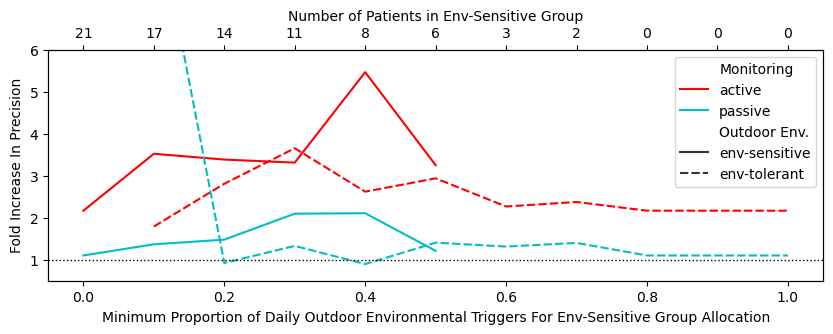

In [ ]:
# plot the median performance 
fig = plt.figure(figsize=(10, 3))
ax1 = sns.lineplot(
    data=all_weather_split_model_summary_plot_df[
        (all_weather_split_model_summary_plot_df['patient'] == 'patient')
        # (all_weather_split_model_summary_plot_df['data'] == 'passive')
    ].sort_values(by=['weather_split','model']),
    x='weather_split', 
    y='auprc_inc', 
    hue='data',
    style='trigger',
    palette=['r','c']
)

# reference line at y=1
plt.axhline(y=1, color='k', linestyle=':', linewidth=1)


handles, labels = ax1.get_legend_handles_labels()
labels[0] = 'Monitoring'
labels[3] = 'Outdoor Env.'
labels[4] = 'env-sensitive'
labels[5] = 'env-tolerant'
ax1.legend(handles=handles, labels=labels)
plt.ylim(0.5, 6)
ax1.set_xlabel('Minimum Proportion of Daily Outdoor Environmental Triggers For Env-Sensitive Group Allocation')
plt.ylabel('Fold Increase In Precision')
# plt.title('Robustness of models across thresholds of patient group allocation')


ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks([0, 0.1, 0.25, 0.5, 0.75, 0.9])
# ax2.set_xticklabels(['21', '17', '14', '6', '2', '0'])
ax2.set_xticks(weather_split_perc)
ax2.set_xticklabels(num_weather_patients)
ax2.set_xlabel('Number of Patients in Env-Sensitive Group')

# save
plt.savefig('./outputs/performance/weather_split_thresholds.svg', dpi=300, bbox_inches='tight')
plt.show()